Complete: 10%
Complete: 20%
Complete: 30%
Complete: 40%
Complete: 50%
Complete: 60%
Complete: 70%
Complete: 80%
Complete: 90%


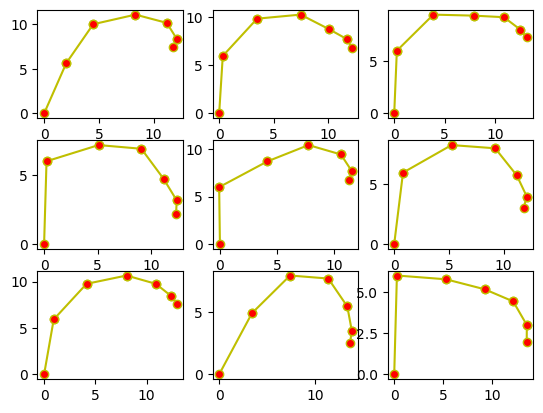

In [4]:
### Line 3-38 was not written by me, it was simply taken from an øving in IMAA2011 Fall 2023 semester.
### It is simply used to draw the robot arm links to a canvas, and perform forward kinematics.
import numpy as np
import matplotlib.pyplot as plt

abs = np.linalg.norm


def fremoverKinematikk(vinkler, lengder):
    punkter = np.zeros((len(vinkler) + 1, 2))
    vinkelSum = 0
    punkter[0, 0] = 0.0
    punkter[0, 1] = 0.0
    for i in range(len(vinkler)):
        vinkelSum = vinkelSum + vinkler[i]
        punkter[i + 1, 0] = punkter[i, 0] + lengder[i] * np.cos(vinkelSum)
        punkter[i + 1, 1] = punkter[i, 1] + lengder[i] * np.sin(vinkelSum)
    return punkter


def tegnRobot(vinkler, lengder, subplot):
    if len(vinkler) != len(lengder):
        print("Du bruker ikke tegnRobot riktig")
    punkter = fremoverKinematikk(vinkler, lengder)
    koblinger = np.array([[i, i + 1] for i in range(len(vinkler))])
    x = punkter[:, 0].flatten()
    y = punkter[:, 1].flatten()
    plt.subplot(subplot[0], subplot[1], subplot[2])
    plt.plot(
        x[koblinger.T],
        y[koblinger.T],
        linestyle="-",
        color="y",
        markerfacecolor="red",
        marker="o",
    )


### Above code was taken from an øving in IMAA2011 Fall 2023 semester.
### It is simply used to draw the robot arm links to a canvas, and perform forward kinematics.


### My code below
from random import random
from time import sleep


class Angleset:
    def __init__(self, angles):
        self.angles = angles
        self.fitness = 0

    def computeFitness(self):
        global link_lengths, target_pos
        current_pos = fremoverKinematikk(self.angles, link_lengths)
        links = len(current_pos)

        # Get position of end effector
        dx = target_pos[0] - current_pos[links - 1][0]
        dy = target_pos[1] - current_pos[links - 1][1]
        self.fitness = dx**2 + dy**2  # distance squared as fitness

    def computeWeightedFitness(self):
        # We prefer if the robot is shaped like an arc as this has more structural integrity and is common for robots.
        # We assume that the target position is in the first quadrant.
        for i in range(1, len(self.angles)):
            if self.angles[i] < 0:
                self.fitness *= 0.1


def generateRandomPop():
    global pop
    for i in range(n_pop):
        # Generate angles within constraints
        _angles = []
        for i in range(angles):
            _angles.append(
                constraints[i][1] + random() * (constraints[i][0] - constraints[i][1])
            )
        # Populate array
        pop.append(Angleset(_angles))

    # Compute weighted fitness
    computeFitness()
    computeWeighted()


def tournamentSelection(population):
    population = sorted(population, key=lambda x: x.fitness)  # Sort low to high
    return population[0]  # Lower fitness is better


def parentSelection():
    global pop
    pop_copy = pop
    parents = []
    tournamentPop = []

    n_parents = int(n_pop * 0.2)
    n_parents -= n_parents % 2  # Make sure we have even number of parents

    for i in range(max(n_parents, 2)):
        for j in range(16):
            r = int(random() * len(pop_copy))  # Get random index
            tournamentPop.append(
                pop_copy[r]
            )  # Append random parent to tournament population
        winner = tournamentSelection(tournamentPop)  # Run tournament
        parents.append(winner)  # Add parent to array for crossover

    return parents


def crossover(parents):
    global pop
    offsprings = []

    for i in range(int(len(parents) / 2)):
        index = i * 2
        if random() > p_c:
            continue

        # Generate first offspring XXYYY
        _angles1 = []
        _angles2 = []

        # Split parents' genes on middle.
        x1 = int(angles / 2)

        for j in range(x1):
            _angles1.append(pop[index].angles[j])
            _angles2.append(pop[index + 1].angles[j])

        for j in range(x1, angles):
            _angles1.append(pop[index + 1].angles[j])
            _angles2.append(pop[index].angles[j])

        offspring1 = Angleset(_angles1)
        offspring2 = Angleset(_angles2)

        # Add offsprings to buffer
        offsprings.append(offspring1)
        offsprings.append(offspring2)

    # Append offsprings to population
    pop = pop + offsprings


def mutate():
    global pop
    for individual in pop:
        for i in range(angles):
            if random() > p_m:  # If above p_m we shouldnt mutate
                continue
            # Mutate
            rate = random() * max_mutation
            if random() > 0.5:  # Decide whether we should add or subtract
                individual.angles[i] += rate
            else:
                individual.angles[i] -= rate

            # Constrain value
            individual.angles[i] = min(
                constraints[i][0], max(constraints[i][1], individual.angles[i])
            )


def computeFitness():
    for p in pop:
        p.computeFitness()


def computeWeighted():
    for p in pop:
        p.computeWeightedFitness()


def sortPop():
    global pop, n_pop
    pop = sorted(pop, key=lambda x: x.fitness)  # Sort from low to high
    pop = pop[:n_pop]  # Keep the first n_pop individuals.


def printAngles(angles):
    print(f"Angles: {angles}")
    for i in range(1, 6):
        print(f"        {angles[i]}")


def GA(subplot):
    global iterations, pop
    generateRandomPop()
    fitnessdata = []

    while iterations < iter_max:
        parents = parentSelection()
        crossover(parents)
        mutate()
        computeFitness()
        computeWeighted()  # We prefer curve as this is common for robots and typically strong
        sortPop()
        iterations += 1

        fitnessdata.append(pop[0].fitness)
        # If we have a curve and are extremely close to the target we can exit the algorithm.
        satisfied = True
        for i in range(1, angles - 1):
            satisfied = satisfied and pop[0].angles[i] < 0 and pop[0].fitness < 1e-10

        if satisfied:
            break
    tegnRobot(pop[n_pop - 1].angles, link_lengths, subplot)


link_lengths = [6, 5, 4, 3, 2, 1]  # Link lengths
angles = len(link_lengths)  # Number of angles = number of links
constraints = [  # Angular constraints
    (np.pi, -np.pi),
    (np.pi * 0.5, -np.pi * 0.5),
    (np.pi * 2 / 3, -np.pi * 0.25),
    (np.pi * 0.5, -np.pi * 0.25),
    (np.pi * 0.5, -np.pi * 0.25),
    (np.pi * 0.5, -np.pi * 0.25),
]


for i in range(1, 10):
    target_pos = [13, 5]  # Target end effector position
    n_pop = 100  # Population size
    p_c = 0.8  # Crossover probabilityThe
    p_m = 0.1  # Mutation probability
    pop = []  # Population buffer
    max_mutation = 0.3  # Maximum mutation in joint angle
    iter_max = 1000  # Max iterations
    iterations = 0  # Current iteration
    GA((3, 3, i))  # Run GA
    print(f"Complete: {i*10}%")

plt.show()
